In [29]:
!pip install h2o
import h2o 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.kmeans import H2OKMeansEstimator
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator

In [30]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 12 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_unknownUser_67ocia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.118 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [53]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'open_account_flg': 'enum'}

In [74]:
data = pd.read_csv('/credit_train.csv', encoding='cp1251', sep=';') # multi-threaded import

In [75]:
data['score_shk'] = data['score_shk'].str.replace(',','.').astype(float)
data['credit_sum'] = data['credit_sum'].str.replace(',','.').astype(float)
# преобразуем указанные переменные в тип object
for i in ['tariff_id']:
    data[i] = data[i].astype('object')
data['living_region'] = data['living_region'].astype(str)
from_replace = ['\s?(ОБЛАСТЬ|ОБЛ\.|ОБЛ|КРАЙ\.|КРАЙ|РЕСПУБЛИКА|РЕСП\.|РЕСП|Г\.\s|Г\s|\sГ|АО|Р-Н)\s?', '74',
                '98|САНКТ-ПЕТЕРБУРГ', 'ЕВРЕЙСКАЯБЛ', 'КАМЧАТСКАЯ|КАМЧАТС\?\?ИЙ', '(МОСКВА|МОСКВОСКАЯ|МЫТИЩИНСКИЙ)',
                '(САХА \(ЯКУТИЯ\)|САХА \/ЯКУТИЯ\/)', 'СЕВ\. ОСЕТИЯ - АЛАНИЯ', 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- ЮГРА',
                'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- Ю', '(ЧУВАШИЯ\sЧУВАШСКАЯ-|ЧУВАШСКАЯ\s?-\sЧУВАШИЯ)', 'БЛ ЕВРЕЙСКАЯ', 
                'БРЯНСКИЙ', 'ГОРЬКОВСКАЯ', 'ОРЁЛ', 'ПЕРМСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ЭВЕНКИЙСКИЙ', 
                'nan|ГУСЬ-ХРУСТАЛЬНЫЙ|МОСКОВСКИЙ\sП|РОССИЯ', 'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА', 'ЧЕЛЯБИНСК$', 'ЧИТИНСКАЯ',
                'ЧУКОТСКИЙ\sАO', 'Г.МОСКОВСКАЯ', 'Г.ОДИНЦОВО\sМОСКОВСКАЯ', 'ДАЛЬНИЙ\sВОСТОК']
to_replace = ['', 'ЧЕЛЯБИНСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'КАМЧАТСКИЙ', 'МОСКОВСКАЯ', 'САХА', 'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
              'ХАНТЫ-МАНСИЙСКИЙ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧУВАШСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'БРЯНСКАЯ', 'НИЖЕГОРОДСКАЯ', 'ОРЛОВСКАЯ', 'ПЕРМСКИЙ', 'МОСКОВСКАЯ', 'КРАСНОЯРСКИЙ', 
              'МОСКОВСКАЯ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧЕЛЯБИНСКАЯ', 'ЗАБАЙКАЛЬСКИЙ', 'ЧУКОТСКИЙ', 
              'МОСКОВСКАЯ', 'МОСКОВСКАЯ', 'ПРИМОРСКИЙ']
data['living_region'].replace(from_replace, to_replace, regex=True, inplace=True)
    
    
data.at[data['job_position'] == 'PNV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'PNS', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'HSK', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'INV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'ONB', 'job_position'] = 'OTHER'

In [76]:
data['age'].fillna(data['age'].median(), inplace=True)
for i in ['credit_sum', 'score_shk']:
    data[i].fillna(data[i].median(), inplace=True)
data['monthly_income'].fillna(30000.0, inplace=True)
for i in ['credit_count', 'overdue_credit_count']:
    data[i].fillna(-1, inplace=True)
data['marital_status'] = data['marital_status'].fillna('MAR')
data['education'].fillna(data['education'].value_counts().index[0], inplace=True)

In [77]:
data = data.drop(['living_region', 'client_id'],axis = 1 ) # в итоге пришлось выкинуть регион проживания, т.к. было слишком должно переписывать всё на англ, а "вода"
# не захотела читать по-русски

In [78]:
frame = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [79]:
frame.head()

gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,monthly_income,credit_count,overdue_credit_count,open_account_flg
M,34,MAR,UMN,59998,10,1.6,0.461599,GRD,30000,1,1,0
F,34,MAR,UMN,10889,6,1.1,0.461599,SCH,30000,2,0,0
M,32,MAR,SPC,10728,12,1.1,0.461599,SCH,30000,5,0,0
F,27,MAR,SPC,12009.1,12,1.1,0.461599,SCH,30000,2,0,0
M,45,MAR,SPC,21229,10,1.1,0.421385,SCH,30000,1,0,0
F,34,MAR,SPC,21229,10,1.1,0.461599,SCH,30000,0,0,0
M,34,MAR,SPC,10317,6,1.5,0.461599,SCH,28000,3,0,0
F,26,UNM,SPC,47878,10,1.1,0.512525,GRD,60000,3,0,0
M,23,UNM,SPC,37577.2,12,1.6,0.461599,SCH,50000,3,0,0
F,32,UNM,SPC,26268,10,1.1,0.465026,GRD,39500,7,0,0


In [80]:
frame.columns

['gender',
 'age',
 'marital_status',
 'job_position',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'education',
 'monthly_income',
 'credit_count',
 'overdue_credit_count',
 'open_account_flg']

In [81]:
# assign target and inputs
y = 'open_account_flg'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

open_account_flg
['gender', 'age', 'marital_status', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'monthly_income', 'credit_count', 'overdue_credit_count']


In [82]:
# determine column types
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)

print(enums)
print(reals)

['gender', 'marital_status', 'job_position', 'education']
['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count']


In [83]:
# standardize for both clustering and PCA

frame[reals] = frame[reals].scale()

In [84]:
# train k-means cluster model
# print summary
clusters = H2OKMeansEstimator(standardize=False, k=5, seed=12345)
clusters.train(x=X, training_frame=frame)
print(clusters)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1603369972294_5


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,170746.0,5.0,4.0,10.0,1.162503e+06,1644068.0,481564.900318




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 1159006.4889025642
Total Sum of Square Error to Grand Mean: 1644068.000025176
Between Cluster Sum of Square Error: 485061.5111226118

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,47793.0,333424.039900
1,,2.0,12938.0,147721.326804
2,,3.0,9144.0,95084.899538
3,,4.0,43880.0,290298.509533
4,,5.0,56991.0,292477.713128



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-10-22 14:05:33,0.008 sec,0.0,NaN,NaN
1,,2020-10-22 14:05:34,1.290 sec,1.0,170746.0,3.209170e+06
2,,2020-10-22 14:05:34,1.434 sec,2.0,29323.0,1.253955e+06
3,,2020-10-22 14:05:34,1.565 sec,3.0,11309.0,1.220683e+06
4,,2020-10-22 14:05:34,1.705 sec,4.0,7776.0,1.208961e+06
5,,2020-10-22 14:05:34,1.800 sec,5.0,12352.0,1.196038e+06
6,,2020-10-22 14:05:34,1.895 sec,6.0,9364.0,1.185417e+06
7,,2020-10-22 14:05:35,2.015 sec,7.0,8174.0,1.176640e+06
8,,2020-10-22 14:05:35,2.107 sec,8.0,6932.0,1.170325e+06
9,,2020-10-22 14:05:35,2.244 sec,9.0,5133.0,1.166022e+06


In [85]:
# join cluster labels to original data for further analysis
labels = clusters.predict(frame)
labeled_frame = frame.cbind(labels)
labeled_frame[-1].head()

kmeans prediction progress: |█████████████████████████████████████████████| 100%


predict
3
4
3
4
4
4
3
3
0
3


In [86]:
labeled_frame

gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,monthly_income,credit_count,overdue_credit_count,open_account_flg,predict
M,-0.236794,MAR,UMN,2.08829,-0.277306,1.17084,-0.0633667,GRD,-0.404818,-0.503451,3.22311,0,3
F,-0.236794,MAR,UMN,-0.936633,-1.40831,-0.949482,-0.0633667,SCH,-0.404818,0.0325133,0.0334202,0,4
M,-0.42644,MAR,SPC,-0.94655,0.288193,-0.949482,-0.0633667,SCH,-0.404818,1.64041,0.0334202,0,3
F,-0.900555,MAR,SPC,-0.86764,0.288193,-0.949482,-0.0633667,SCH,-0.404818,0.0325133,0.0334202,0,4
M,0.80626,MAR,SPC,-0.299729,-0.277306,-0.949482,-0.386987,SCH,-0.404818,-0.503451,0.0334202,0,4
F,-0.236794,MAR,SPC,-0.299729,-0.277306,-0.949482,-0.0633667,SCH,-0.404818,-1.03942,0.0334202,0,4
M,-0.236794,MAR,SPC,-0.971866,-1.40831,0.746776,-0.0633667,SCH,-0.484678,0.568478,0.0334202,0,3
F,-0.995378,UNM,SPC,1.34175,-0.277306,-0.949482,0.346458,GRD,0.79307,0.568478,0.0334202,0,3
M,-1.27985,UNM,SPC,0.707254,0.288193,1.17084,-0.0633667,SCH,0.393774,0.568478,0.0334202,0,0
F,-0.42644,UNM,SPC,0.0106536,-0.277306,-0.949482,-0.035788,GRD,-0.025487,2.71234,0.0334202,0,3


In [87]:
# profile clusters by means
grouped = labeled_frame.group_by(by=['predict'])
means = grouped.mean(col=reals).get_frame()
print(means)

predict,mean_age,mean_credit_sum,mean_credit_month,mean_tariff_id,mean_score_shk,mean_monthly_income,mean_credit_count,mean_overdue_credit_count
0,-0.397187,0.0501739,-0.14953,1.03762,1.01362,-0.218986,-0.399607,-0.209179
1,0.03172,1.73559,-0.0890107,0.0274755,-0.219949,2.04715,0.219094,0.12809
2,0.0280553,0.630307,3.39219,-0.272166,-0.120267,-0.0769416,0.145579,0.0281877
3,-0.0576824,-0.0628639,-0.197894,-0.305372,-0.563448,0.205869,0.747711,0.314081
4,0.365794,-0.488816,-0.246293,-0.597604,-0.346978,-0.42726,-0.31368,-0.100008


In [88]:
# profile clusters by modes
grouped = labeled_frame.group_by(by=['predict'])
modes = grouped.mode(col=enums).get_frame()
print(modes)

predict,mode_gender,mode_marital_status,mode_job_position,mode_education
0,0,3,9,3
1,1,2,9,1
2,0,2,9,3
3,1,2,9,1
4,0,2,9,3


In [89]:
# define a function for plotting clusters in 2-d
def plot(_2d_labeled_frame):

    _0 = plt.scatter(features_pandas[_2d_labeled_frame.label == 0].iloc[0:750, 0], 
                     features_pandas[_2d_labeled_frame.label == 0].iloc[0:750, 1],
                     color='m', marker='^', alpha=.15)

    _1 = plt.scatter(features_pandas[_2d_labeled_frame.label == 1].iloc[0:750, 0], 
                     features_pandas[_2d_labeled_frame.label == 1].iloc[0:750, 1],
                     color='c', alpha=.15)

    _2 = plt.scatter(features_pandas[_2d_labeled_frame.label == 2].iloc[0:750, 0], 
                     features_pandas[_2d_labeled_frame.label == 2].iloc[0:750, 1],
                     color='g', marker='s', alpha=.15)          
    _3 = plt.scatter(features_pandas[_2d_labeled_frame.label == 3].iloc[0:750, 0], 
                     features_pandas[_2d_labeled_frame.label == 3].iloc[0:750, 1],
                     color='y', marker='s', alpha=.15)      
    _4 = plt.scatter(features_pandas[_2d_labeled_frame.label == 4].iloc[0:750, 0], 
                     features_pandas[_2d_labeled_frame.label == 4].iloc[0:750, 1],
                     color='r', marker='s', alpha=.15)           
                     
    plt.legend([_0, _1, _2, _3, _4], 
               ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
               bbox_to_anchor=(1.05, 0.0), 
               loc=3, borderaxespad=0.)
    
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

pca Model Build progress: |███████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/job.py:70: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
        PC1       PC2       PC3       PC4       PC5  label
0 -0.313628  1.752810  1.644603  0.098752  0.347064      3
1 -0.281480 -1.498655  0.035341  0.904886  0.565131      4
2 -1.085478 -0.590177  0.248480 -0.452581  1.265739      3
3 -0.054574 -0.806855 -0.347471 -0.403087  1.238772      4
4 -0.579507 -1.004132 -0.486492 -0.172327 -0.487769      4


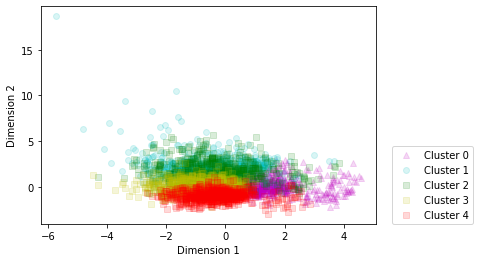

In [90]:
# project training data onto 2-D using principal components
# join with clusters labels
# plot
pca = H2OPrincipalComponentAnalysisEstimator(k=5) # project onto 2 PCs
pca.train(x=reals, training_frame=labeled_frame)
features = pca.predict(labeled_frame)
features_pandas = features.as_data_frame()
features_pandas['label'] = labeled_frame[-1].as_data_frame()
print(features_pandas.head())
plot(features_pandas)